In [1]:
import sys, skvideo.io, json, base64
import numpy as np
from PIL import Image
from io import BytesIO, StringIO
from pathlib import Path

In [2]:
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18, resnet34
torch.backends.cudnn.benchmark=True


In [3]:
import torchvision.transforms.functional as TVF

## Models

In [4]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [5]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p, inplace=True))

In [6]:
class Unet34(nn.Module):
    def __init__(self, f=resnet34):
        super().__init__()
        m_base, lr_cut = get_base(f)
        self.rn = m_base
        self.lr_cut = lr_cut
        self.sfs = [SaveFeatures(self.rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = UnetBlock(256,3,16)
        self.up6 = nn.ConvTranspose2d(16, 2, 1)
        
    def forward(self,x):
        inp = x
        x = F.relu(self.rn(x), inplace=True)
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x, inp)
        x = self.up6(x)
        return torch.squeeze(x)
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [17]:
from torchvision.models import vgg11_bn
def children(m): return m if isinstance(m, (list, tuple)) else list(m.children())
def vgg11(pre): return children(vgg11_bn(pre))[0]
class Unet11Mini(nn.Module):
    def __init__(self, f=vgg11):
        super().__init__()
        m_base, lr_cut = get_base(f)
        self.rn = m_base
        self.lr_cut = lr_cut
        self.sfs = [SaveFeatures(self.rn[0][i]) for i in [2,6,13,20,27]]
        self.up0 = UnetBlock(512,512,256)
        self.up1 = UnetBlock(256,512,256)
        self.up2 = UnetBlock(256,256,256)
        self.up3 = UnetBlock(256,128,128)
        self.up4 = UnetBlock(128,64,64)
        self.up5  = nn.Conv2d(64,2,1)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up0(x, self.sfs[4].features)
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        return x

In [18]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        if isinstance(self.model, FP16):
            model = self.model.module
        else:
            model = self.model
        lgs = list(split_by_idxs(children(model.rn), [model.lr_cut]))
        return lgs + [children(model)[1:]]


In [19]:
def cut_model(m, cut):
    return list(m.children())[:cut] if cut else [m]

def get_base(f):
    cut,lr_cut = model_meta[f]
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers), lr_cut

In [20]:

model_meta = {
    resnet18:[8,6], resnet34:[8,6], vgg11:[0,13]
}

In [21]:
m = Unet11Mini()

In [22]:
def batchnorm_to_fp32(module):
    '''
    BatchNorm layers to have parameters in single precision.
    Find all layers and convert them back to float. This can't
    be done with built in .apply as that function will apply
    fn to all modules, parameters, and buffers. Thus we wouldn't
    be able to guard the float conversion based on the module type.
    '''
    if isinstance(module, nn.modules.batchnorm._BatchNorm):
        module.float()
    for child in module.children():
        batchnorm_to_fp32(child)
    return module
class FP16(nn.Module):
    def __init__(self, module): 
        super(FP16, self).__init__()
        self.module = batchnorm_to_fp32(module.half())
        
    def forward(self, input): 
        return self.module(input.half())
    
    def load_state_dict(self, *inputs, **kwargs):
        self.module.load_state_dict(*inputs, **kwargs)

    def state_dict(self, *inputs, **kwargs):
        return self.module.state_dict(*inputs, **kwargs)

In [13]:
m = FP16(m)

In [23]:
PATH = Path('../data/all')

In [24]:
cuda_enabled = torch.cuda.is_available()
model_path = str(PATH/'models/600urn-35-unet11-mini-nocrop.h5')
if cuda_enabled:
    m = m.cuda()
    m.load_state_dict(torch.load(model_path, map_location=lambda storage, loc: storage))
else:
    m.load_state_dict(torch.load(model_path))


In [25]:
# file = sys.argv[-1]
file = 'test_video.mp4'

if file == 'demo.py':
  print ("Error loading video")
  quit

# Define encoder function
def encode(array):
	pil_img = Image.fromarray(array)
	buff = BytesIO()
	pil_img.save(buff, format="PNG")
	return base64.b64encode(buff.getvalue()).decode("utf-8")

video = skvideo.io.vread(file)


In [26]:
import matplotlib.pyplot as plt

In [27]:
# resized_video = np.array([scipy.misc.imresize(f, size=(512,512)) for f in video])

In [28]:
# plt.imshow(video[0][226:546,:,:])

In [29]:
imagenet_stats = torch.cuda.FloatTensor([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
def normalize(x):
    if x.mean() > 1:
        x.div_(255.0)
    m,s = imagenet_stats
#     return TVF.normalize(x, m, s)
    print(x.shape)
    x.sub_(m.view(-1, 1, 1))
    x.div_(s.view(-1, 1, 1))
    return x

def crop_bg(x):
    # Original
    h = x.shape[2]
    top = int(h/3.75)
    bot = int(h*.9 + h/150)
    return x[:,:,top:bot,:]

def pad(x):
#     print(x.shape)
    # Original
    b,c,w,h = x.shape
    print(x.shape)
    if h%32 == 0:
        return x, 0
    pad_right=32-h%32
    if pad_right:
        x = F.pad(x, (0,pad_right,0,0), 'constant', 0)
    return x, pad_right
    
def undo(idx):
    idx
    idx = F.pad(idx, (0,0,226,54), "constant", 0)

def preprocess(video):
#     f1 = video[:,200:520,:,:]
    f1 = np.rollaxis(video, 3, 1)
    f1 = torch.from_numpy(f1).float().cuda()
    f1 = crop_bg(f1)
    f1 = normalize(f1)
    return f1.contiguous()

In [30]:
video.shape

(31, 600, 800, 3)

In [31]:
video_p = preprocess(video)

torch.Size([31, 3, 384, 800])


In [32]:
video_p = torch.cat((video_p[:15], video_p[16:]))

In [33]:
video_p.shape

torch.Size([30, 3, 384, 800])

In [34]:
import gc
gc.collect()

14

In [35]:
# xv = torch.autograd.Variable(torch.from_numpy(video_p).contiguous().float())

In [123]:
f_results = []
results = []
answer_key = {}
bs = 4

        
for i in range(0,video_p.shape[0],bs):
    x = video_p[i:i+bs]
    
#     x = torch.from_numpy(f1).contiguous().float()
#     if cuda_enabled:
#         x = x.cuda()
        
    x,p = pad(x)
    preds = m(torch.autograd.Variable(x))
    preds = F.sigmoid(preds)
    # Indexes
#     mx,idx = torch.max(preds, 1)
#     if p > 0:
#         idx = idx[:,:,:-p]
#     idx = F.pad(idx, (0,0,160,56), "constant", 0)
#     frame_idx = 1+i
#     for frame in idx:
#         frame = frame.data.cpu().numpy()
#         results.append(frame)
#         binary_car_result = (frame==1).astype('uint8')
#         binary_road_result = (frame==2).astype('uint8')
#         answer_key[frame_idx] = [encode(binary_car_result), encode(binary_road_result)]
#         frame_idx+=1
    
    # Preds
    if p > 0:
        preds = preds[:,:,:,:-p]
    preds = F.pad(preds, (0,0,160,56,0,0), "constant", 0)
    frame_idx = 1+i
    for frame in preds:
        frame = frame.data.cpu().float().numpy()
        f_results.append(frame)
        binary_car_result = (frame[0]>0.5).astype('uint8')
        binary_road_result = (frame[1]>0.5).astype('uint8')
        answer_key[frame_idx] = [encode(binary_car_result), encode(binary_road_result)]
        results.append([binary_car_result, binary_road_result])
        frame_idx+=1

torch.Size([4, 3, 384, 800])


OSError: cannot write mode F as PNG

In [47]:
results[0].shape

(2, 600, 800)

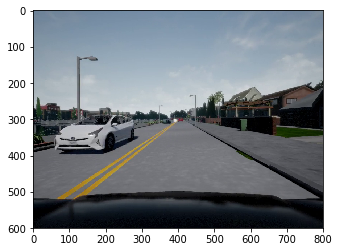

In [48]:
plt.imshow(video[14])

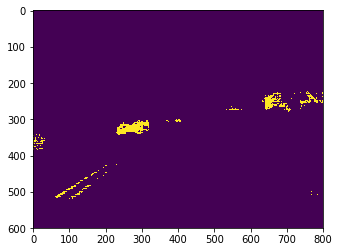

In [122]:
plt.imshow((f_results[10][0]==1).data)

In [67]:
# Print output in proper json format
tester_data = json.dumps(answer_key)
with open('tester_data_crop', 'w') as f:
    f.write(tester_data)
print(json.dumps(answer_key))

{"1": ["iVBORw0KGgoAAAANSUhEUgAAAyAAAAJYCAAAAAC/Hd2sAAAd90lEQVR4nO3dWZajOBBAUUWd3P+WVR9onsVkEO9mV2faxoAxgWahFAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADg9UQpUaJ/vRvABNl+aaVEi9LmOfPbnMzpSe0fixaltGw/9kmdBYHY9f3zW/Q7EP4o97v0avJWVMwcp9Jx9d+F//cdokRk+7+I/egi9gov25+iZPtv+y12efOnfbc/pcsHMXjFvI8UBO8gOrg0DJ+2oqMf827Rdn31FYlSqpCCbC/FQSbF10hBrlBLIb57rMWnD5I869OJ+LwU97uc5RF/PIN0pbztcgRJni8Dfmg7HxvlhvK7tmXTp4ffK2mSZVYYJEXbT7LB7Hmcwx5fd0KYv+Pf35EUp+vSLFQpLKLllRKzSOGQilY2LZe4/B8tATxMmIL4y0hhOVfGCJgAGj21bXnevtHHoI3EQkohpB6XKh3v8PcTL11X7lFSuK4Li+EDKU79FI63VimDbJvpbgVYmCil/okphtgKgrC2uFA7ENcSyEDeEPgBV/N1YA1mPeU2yC2LtX/1wNuZdhCxSYh51jQ8+r+jxscgDQnbNYHHOXJy+gYTU1TJarHM70Y7Y6MOAXg/3w4S1mL5x1bcJpKshAj5ul/WaLrK3LyAcMJexe0gSXtJPwUB1ham

### F1 Score

In [68]:
import sys
import json
import base64
import numpy as np
from scipy import misc

In [125]:
# student_output = sys.argv[1]
R_PATH = Path.cwd()
student_output = R_PATH/'tester_data_crop'

In [126]:
import pdb

In [127]:
def decode(packet):
	img = base64.b64decode(packet)
	filename = R_PATH/'image.png'
	with open(filename, 'wb') as f:
			f.write(img)
	result = misc.imread(filename)
	return result

with open(R_PATH/'results.json') as json_data:
	ans_data = json.loads(json_data.read())
	json_data.close()

# Load student data
with open(student_output) as student_data:
	student_ans_data = json.loads(student_data.read())
	student_data.close()

frames_processed = 0

Car_TP = 0 # True Positives
Car_FP = 0 # Flase Positives
Car_TN = 0 # True Negatives
Car_FN = 0 # True Negatives

Road_TP = 0 # True Positives
Road_FP = 0 # Flase Positives
Road_TN = 0 # True Negatives
Road_FN = 0 # True Negatives

tc = []
tr = []
pc = []
pr = []
for frame in range(1,len(ans_data.keys())+1):

    truth_data_car =  decode(ans_data[str(frame)][0])
    truth_data_road =  decode(ans_data[str(frame)][1])
    student_data_car = decode(student_ans_data[str(frame)][0])
    student_data_road = decode(student_ans_data[str(frame)][1])
    tc.append(truth_data_car)
    tr.append(truth_data_road)
    pc.append(student_data_car)
    pr.append(student_data_road)

/home/paperspace/anaconda3/envs/lyft/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


In [129]:
def f2_score(y_true, y_pred, threshold=0.5):
    return fbeta_score(y_true, y_pred, 2, threshold)


def fbeta_score(y_true, y_pred, beta, threshold=None, eps=1e-9):
    beta2 = beta**2

    if threshold:
        y_pred = torch.ge(y_pred.float(), threshold).float()
    else:
        y_pred = y_pred.float()
    y_true = y_true.float()

    true_positive = (y_pred * y_true).sum()
    precision = true_positive/(y_pred.sum()+(eps))
    recall = true_positive/(y_true.sum()+eps)
    
    fb = (precision*recall)/(precision*beta2 + recall + eps)*(1+beta2)
    
    return fb, true_positive, precision, recall

In [130]:
tc_s = np.stack(tc)
tr_s = np.stack(tr)
pc_s = np.stack(pc)
pr_s = np.stack(pr)

In [131]:
y_true = torch.from_numpy(tc_s).float()
y_pred = torch.from_numpy(pc_s).float()

In [132]:
eps=1e-9
true_positive = (y_pred * y_true).sum()
precision = true_positive/(y_pred.sum()+(eps))
recall = true_positive/(y_true.sum()+eps)

In [134]:
fbeta_score(torch.from_numpy(tc_s), torch.from_numpy(pc_s), 2)

(0.45167653124913826, 120311.0, 0.1773684932132898, 0.7363920699722686)

In [133]:
fbeta_score(torch.from_numpy(tr_s), torch.from_numpy(pr_s), .5)

(0.7476154659013783, 2705471.0, 0.7148761629908698, 0.9152853789247656)

In [135]:
def decode(packet):
	img = base64.b64decode(packet)
	filename = R_PATH/'image.png'
	with open(filename, 'wb') as f:
			f.write(img)
	result = misc.imread(filename)
	return result

with open(R_PATH/'results.json') as json_data:
	ans_data = json.loads(json_data.read())
	json_data.close()

# Load student data
with open(student_output) as student_data:
	student_ans_data = json.loads(student_data.read())
	student_data.close()

frames_processed = 0

Car_TP = 1 # True Positives
Car_FP = 1 # Flase Positives
Car_TN = 1 # True Negatives
Car_FN = 1 # True Negatives

Road_TP = 1 # True Positives
Road_FP = 1 # Flase Positives
Road_TN = 1 # True Negatives
Road_FN = 1 # True Negatives

for frame in range(1,len(ans_data.keys())+1):

    truth_data_car =  decode(ans_data[str(frame)][0])
    truth_data_road =  decode(ans_data[str(frame)][1])
    student_data_car = decode(student_ans_data[str(frame)][0])
    student_data_road = decode(student_ans_data[str(frame)][1])
#     student_data_car = results[frame-1][0]
#     student_data_road = results[frame-1][1]
#     student_data_car = f_results[frame-1][0]
#     student_data_road = f_results[frame-1][1]
#     print(np.mean(student_data_road == 1))
#     print(np.mean(student_data_road_f == 1))
#     pdb.set_trace()

    Car_TP += np.sum(np.logical_and(student_data_car == 1, truth_data_car == 1))
    Car_FP += np.sum(np.logical_and(student_data_car == 1, truth_data_car == 0))
    Car_TN += np.sum(np.logical_and(student_data_car == 0, truth_data_car == 0))
    Car_FN += np.sum(np.logical_and(student_data_car == 0, truth_data_car == 1))

    Road_TP += np.sum(np.logical_and(student_data_road == 1, truth_data_road == 1))
    Road_FP += np.sum(np.logical_and(student_data_road == 1, truth_data_road == 0))
    Road_TN += np.sum(np.logical_and(student_data_road == 0, truth_data_road == 0))
    Road_FN += np.sum(np.logical_and(student_data_road == 0, truth_data_road == 1))

    frames_processed+=1


# Generate results
Car_precision = Car_TP/(Car_TP+Car_FP)/1.0
Car_recall = Car_TP/(Car_TP+Car_FN)/1.0
Car_beta = 2
Car_F = (1+Car_beta**2) * ((Car_precision*Car_recall)/(Car_beta**2 * Car_precision + Car_recall))
Road_precision = Road_TP/(Road_TP+Road_FP)/1.0
Road_recall = Road_TP/(Road_TP+Road_FN)/1.0
Road_beta = 0.5
Road_F = (1+Road_beta**2) * ((Road_precision*Road_recall)/(Road_beta**2 * Road_precision + Road_recall))

print ("Car F score: %05.3f  | Car Precision: %05.3f  | Car Recall: %05.3f  |\n\
Road F score: %05.3f | Road Precision: %05.3f | Road Recall: %05.3f | \n\
Averaged F score: %05.3f" %(Car_F,Car_precision,Car_recall,Road_F,Road_precision,Road_recall,((Car_F+Road_F)/2.0)))

/home/paperspace/anaconda3/envs/lyft/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


Car F score: 0.452  | Car Precision: 0.177  | Car Recall: 0.736  |
Road F score: 0.748 | Road Precision: 0.715 | Road Recall: 0.915 | 
Averaged F score: 0.600


In [118]:
Road_TP, Road_FP, Road_TN, Road_FN

(0, 60, 30, 0)

In [106]:
Road_TP, Road_FP, Road_TN, Road_FN

(1780363, 119898, 11324225, 1175514)

In [108]:
Road_TP, Road_FP, Road_TN, Road_FN

(24029, 186, 5184000, 0)